In [15]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal
from functools import partial
from IPython.display import GeoJSON
py.init_notebook_mode()

In [20]:
ny = pd.read_csv('/content/pluto_22v3_1.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'])]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (21,22,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.



In [31]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['xcoord'] = 0.3048*ny['xcoord']
ny['ycoord'] = 0.3048*ny['ycoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [22]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '27853f4d-5c08-412b-9704-3c773ef236cf',
 …

In [23]:
import warnings
warnings.filterwarnings('ignore')

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [24]:
df = ny[['yearbuilt','numfloors']]
df['y10'] = (df['yearbuilt'] // 10 * 10).astype(int)
bins = (0,1,2,3,10,20,30,70,200)
count_df = df.groupby(['y10',pd.cut(df['numfloors'],bins)]).count().drop(['numfloors'],axis=1).fillna(0).reset_index()

In [26]:
groups = count_df.groupby('numfloors')
fig = go.Figure()

for i in groups.groups:
  group = groups.get_group(i)
  fig.add_trace(go.Bar(x=group['y10'],y=group['yearbuilt'],name=str(i)))
fig.update_layout(barmode='stack',xaxis={'categoryorder':'category ascending'})
fig.show()

In [27]:
fig = go.FigureWidget(
    data = [
        go.Histogram2d(x=ny['yearbuilt'], y=ny['numfloors'], autobiny=False, ybins={'size': 1}, colorscale='Greens')
    ]
)

fig

FigureWidget({
    'data': [{'autobiny': False,
              'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125…

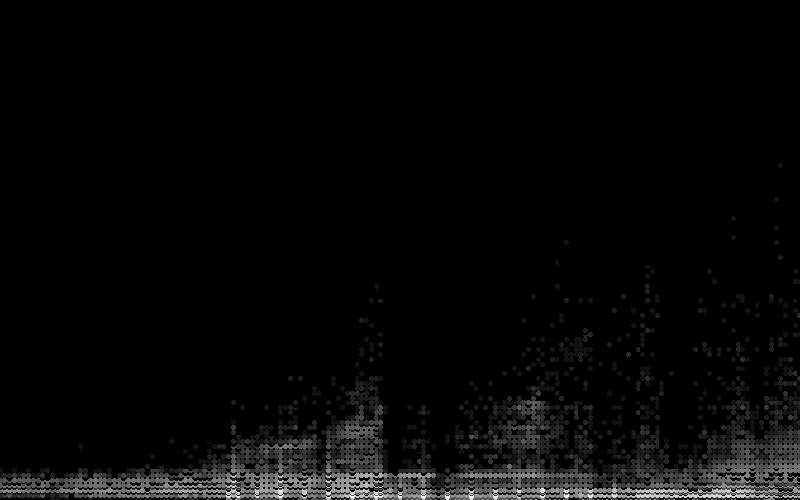

In [28]:
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

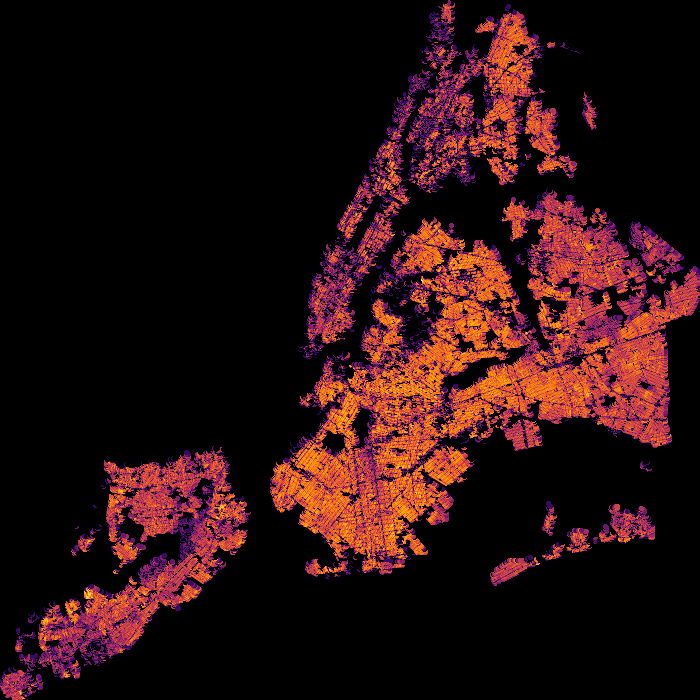

In [29]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

In [32]:
ny['structure'] = ny['assesstot'] - ny['assessland']

sdf = pd.DataFrame(ny[['assessland','structure','lat','lon']])
sdf['l_segment'] = 'med'
sdf.loc[sdf['assessland']<7500,'l_segment'] = 'low'
sdf.loc[sdf['assessland']>=12500,'l_segment'] = 'high'

sdf['s_segment'] = 'med'
sdf.loc[sdf['structure']<16000,'s_segment'] = 'low'
sdf.loc[sdf['structure']>=25000,'s_segment'] = 'high'

sdf['segment'] = pd.Categorical(sdf['l_segment']+'-'+sdf['s_segment'])
sdf.describe()

assessland     structure            lat            lon
count  8.092180e+05  8.092180e+05  809218.000000  809218.000000
mean   1.112733e+05  4.119044e+05      40.300957     -76.429179
std    4.170819e+06  7.549806e+06       0.025955       0.035023
min    0.000000e+00  0.000000e+00      40.239998     -76.528856
25%    1.038000e+04  2.952000e+04      40.280826     -76.447127
50%    1.416000e+04  4.224000e+04      40.299389     -76.426571
75%    2.190000e+04  7.830000e+04      40.317645     -76.404425
max    3.205634e+09  4.343287e+09      40.368738     -76.363162

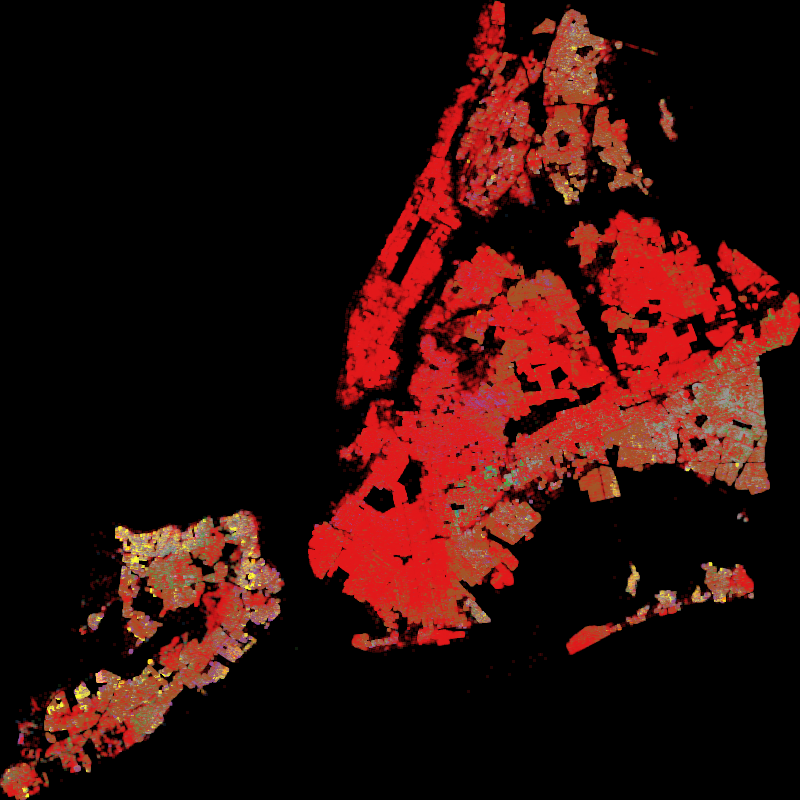

In [33]:
nyc = ((-76.528856, -76.363162),(40.239998, 40.368738))
can = ds.Canvas(800,800,*nyc)
ag = can.points(sdf, 'lon', 'lat', ds.count_cat('segment'))
view = tf.shade(ag, )
export(tf.spread(view, px=1), 'pretty_colors')

Manhattan is completely overbuilt as per the visualization. I can see a few areas within Queens and Brooklyn that are overbuilt as well. Most of the underbuilt areas are Staten Island and the Bronx with a few within Queens and Brooklyn. 